# <span style=color:darkblue>CLASSIFICATION (Binary Logistic Regression)</span>

**REFERENCIAS**

- https://www.datascienceinstitute.net/blog/binary-logistic-regression-in-python-a-tutorial-part-1
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html (RFE)

In [190]:
# Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [191]:
# Carga de los datos
pd.set_option('display.max_columns', None)
ahogamientos = pd.read_csv("/Users/adrianova/Desktop/git/TFM - Notebooks/datos_ahogamiento_meteorologicos2.csv",  encoding='utf-8')
ahogamientos.head(2)

,Fecha,IdAhogado,IdPersona,Localidad,Provincia,CCAA,Hora,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Titular,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Riesgo,Reanimacion,Vigilancia,Actividad,Deteccion,Enlace1,Indicador,Estacion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,30-12-2020,7432,8532,Torredembarra,Tarragona,Cataluña,NaN,41.130523,1.395311,NaN,NaN,España,NaN,Embarcación de rescate,Encuentran un cadáver flotando en el mar cerca...,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,NaN,Recuperacion de cadaver,No vigilado,NaN,Ciudadano,#https://www.diarimes.com/es/noticias/camp_tar...,9981A,ESTACIÓN DE TORTOSA (ROQUETES),50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,29-12-2020,7431,8531,"Cádiz, Playa de Santa Maria del Mar",Cádiz,Andalucía,17:48,36.519991,-6.287258,NaN,NaN,España,NaN,Ciudadano,Evacuada al hospital en estado grave una perso...,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,NaN,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,#https://elcorreoweb.es/andalucia/encuentran-u...,5973,CÁDIZ,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,NaN,1017.0,1011.4


In [192]:
# 8015 observaciones y 40 columnas
ahogamientos.shape

(8015, 40)

## <span style=color:darkblue>Limpieza de los datos</span>

+ Hay columnas que de por si no son relevantes a la hora de aplicar algoritmos de aprendizaje automático como lo son los identificadores o variables que son explicadas por otras:

    - **IdAhogado:** es un identificador
    - **IdPersona:** es un identificador
    - **Indicador:** es un identificador 
    - **Localidad:** queda explicada por CCAA y con menos categorías
    - **Provincia:** queda explicada por CCAA y con menos categorías
    - **Fecha, Hora, Titular, Enlace1, Estación**: no aporta información al modelo

In [193]:
# Eliminamos las columnas que estamos 100% seguros que no aportan valor
ahogamientos_df = ahogamientos.copy()
ahogamientos_df.drop(["IdAhogado", "IdPersona","Indicador", "Localidad", \
                      "Provincia", "Fecha", "Hora", "Titular", "Enlace1", "Estacion"], axis = 1, inplace = True)
ahogamientos_df.head(2)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Riesgo,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,Cataluña,41.130523,1.395311,NaN,NaN,España,NaN,Embarcación de rescate,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,NaN,Recuperacion de cadaver,No vigilado,NaN,Ciudadano,50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,Andalucía,36.519991,-6.287258,NaN,NaN,España,NaN,Ciudadano,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,NaN,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,NaN,1017.0,1011.4


In [194]:
# 8015 observaciones y 30 columnas
ahogamientos_df.shape

(8015, 30)

+ De las variables restantes pueden haber algunas más interesantes que otras para el modelo de clasificación. Para ello es importante conocer los valores faltantes que nos puede ayudar a determinar que variables son relevantes y cuáles no.

In [195]:
round(ahogamientos_df.isna().sum()/ahogamientos_df.shape[0],4) * 100

CCAA                0.00
Latitud             0.00
Longitud            0.00
Sexo                4.97
Edad               19.70
Nacionalidad        1.16
Origen             43.87
Extraccion          1.32
Causa              28.10
TipoAhogamiento     0.30
Factor             58.22
Intervencion        0.97
Pronostico          0.26
Localizacion        0.00
Riesgo             61.37
Reanimacion         2.83
Vigilancia          0.34
Actividad           4.15
Deteccion           1.71
Altitud             0.00
TempMed             0.42
Precip              4.63
TempMin             0.42
TempMax             0.36
DirViento           2.28
VelMedViento        2.01
RachaViento         2.28
TiempoSol           7.70
PresionMax          0.71
PresionMin          0.70
dtype: float64

+ Hay ciertas variables que pueden ser importantes para revelar patrones de comportamiento como lo son el origen, la causa, el factor y el riesgo de ahogamiento pero que mantienen demasiados valores faltantes y que nos desharemos de todas ellas excepto de la causa, ya que es la que mantiene menos valores faltantes y aplicaremos imputación de missings con la moda. 


+ Por otro lado, la variable Edad tiene aproximadamente un 20% de valores faltantes, solo nos quedaremos con los datos por los que tenemos datos en la variable edad, ya que es una variable suficiente trascendental como aplicar imputación. 


+ Para las variables categóricas realizaremos imputación de missings con la moda, ya que el número de valores faltantes es muy bajo.


+ Para las variables meteorológicas realizaremos imputación de missings sobre la mediana, ya que el número de valores faltantes es muy bajo.

In [196]:
# Eliminamos los valores en que la variable Edad tiene Nans por conveniencia
ahogamientos_df = ahogamientos_df.dropna(subset = ["Edad"])

# Eliminamos las variables Factor, Origen y Riesgo por almacenar demasiados valores faltantes
ahogamientos_df.drop(["Origen", 'Factor', "Riesgo"], axis = 1, inplace = True)

In [197]:
# Imputación de missings con el valor más frecuente
no_data_columns = ["Sexo", "Causa", "Nacionalidad", "Extraccion", "TipoAhogamiento", "Intervencion", "Pronostico", "Reanimacion", "Vigilancia", "Actividad", "Deteccion"]
      
for var in no_data_columns:
    moda = ahogamientos_df[var].mode().iloc[0]
    ahogamientos_df[var] = ahogamientos_df[var].fillna(moda)

In [198]:
# Realizamos imputación de missings sobre las variables meteorologicas
median_imputation = ["TempMed", "Precip", "TempMin", "TempMax", "DirViento",\
"VelMedViento", "RachaViento","TiempoSol", "PresionMax", "PresionMin"]

# Calculo de la mediana de cada variable
medians = ahogamientos_df[median_imputation].median()

for median in median_imputation:
    ahogamientos_df[median] = ahogamientos_df[median].fillna(medians[median])

+ Creamos una variable adicional que determinará si un ahogamiento ha sido mortal (1) de uno que no lo ha sido (0) a partir de la variable **Pronóstico** dentro del dataset de ahogamientos.

In [199]:
# Creamos variable fictícia si se ha producido ahogamiento 1 o no 0
ahogamientos_df["AhogamientoMortal"] = np.where(ahogamientos_df["Pronostico"] == "Ahogamiento mortal", 1, 0)                                                                                                                                                                  
ahogamientos_df.head(2)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Extraccion,Causa,TipoAhogamiento,Intervencion,Pronostico,Localizacion,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin,AhogamientoMortal
2,País Vasco,43.317215,-1.977996,Hombre,47.0,España,Cuerpo de Seguridad o Emergencias,Accidente de Trafico,Ahogamiento secundario a accidente,Recuperación de cadaver,Ahogamiento mortal,"Puertos, embarcaderos, amarres",Recuperacion de cadaver,No vigilado,Circulación en vehiculo,"Acompañante, familiar, amigo",251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1,1
3,País Vasco,43.317215,-1.977996,Hombre,33.0,España,No preciso extraccion,Accidente de Trafico,Perdida de Control,Recuperación de cadaver,Rescate y traslado a supervisión médica,"Puertos, embarcaderos, amarres",Sin Reanimacion,No vigilado,Circulación en vehiculo,"Acompañante, familiar, amigo",251,5.4,36.6,3.8,7.0,26.0,8.9,18.1,0.0,977.5,968.1,0


In [200]:
# Eliminamos las variables Longitud y Latitud, ya que son variables que no aportan información sobre nuestro modelo
ahogamientos_df = ahogamientos_df.drop(['Latitud', 'Longitud'], axis=1)

In [201]:
# 6436 observaciones y 26 columnas
ahogamientos_df.shape

(6436, 26)

## <span style=color:darkblue>Selección de variables para el modelo</span>

1    3232
0    3204
Name: AhogamientoMortal, dtype: int64


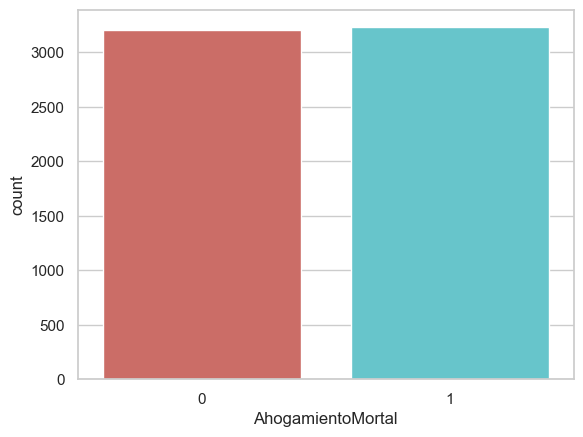

In [202]:
# observamos la distribución de la variable ahogamiento mortal
print(ahogamientos_df['AhogamientoMortal'].value_counts())

# Plot
sns.countplot(x = 'AhogamientoMortal', data = ahogamientos_df, palette = 'hls')
plt.show()

+ Se observa como esta muy balanceado el ahogamiento mortal de un ahogamiento no mortal.

## <span style=color:darkblue>Dummies sobre las variables categóricas</span>

In [203]:
# Variables categoricas. Aplicación de la técnica dummies sobre las variables categóricas
cat_vars = list(ahogamientos_df.select_dtypes('object').columns)

for var in cat_vars:
    cat_list = 'var' + '_' + var
    cat_list = pd.get_dummies(ahogamientos_df[var], prefix = cat_list)
    ahogamientos_df_1 = ahogamientos_df.join(cat_list)
    ahogamientos_df = ahogamientos_df_1
    
    
cat_vars = list(ahogamientos_df.select_dtypes('object').columns)
data_vars = ahogamientos_df.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

In [204]:
# Aplicamos dummies sobre el dataframe original
ahogamientos_df_final = ahogamientos_df[to_keep]

In [205]:
# Dataframe final con variables numéricas y categóricas (dummies)
ahogamientos_df_final.head(3)

,Edad,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin,AhogamientoMortal,var_CCAA_Andalucía,var_CCAA_Aragón,var_CCAA_Asturias,var_CCAA_Canarias,var_CCAA_Cantabria,var_CCAA_Castilla La Mancha,var_CCAA_Castilla y León,var_CCAA_Cataluña,var_CCAA_Ceuta,var_CCAA_Ciudad Valenciana,var_CCAA_Extremadura,var_CCAA_Galicia,var_CCAA_Islas Baleares,var_CCAA_La Rioja,var_CCAA_Madrid,var_CCAA_Melilla,var_CCAA_Murcia,var_CCAA_Navarra,var_CCAA_País Vasco,var_Sexo_Hombre,var_Sexo_Mujer,var_Nacionalidad_España,var_Nacionalidad_Otro,"var_Extraccion_Acompañante, familiar, amigo",var_Extraccion_Ciudadano,var_Extraccion_Cuerpo de Seguridad o Emergencias,var_Extraccion_Embarcacion costera,var_Extraccion_Embarcación de recreo,var_Extraccion_Embarcación de rescate,var_Extraccion_Fuerzas orden publico,var_Extraccion_Helicoptero,var_Extraccion_Moto acuática de rescate,var_Extraccion_No preciso extraccion,var_Extraccion_Otros,var_Extraccion_Socorrista,var_Extraccion_Socorrista con material,var_Extraccion_Tabla de rescate,var_Causa_Accidente de Trafico,"var_Causa_Accidente, caída o zambullida accidentales",var_Causa_Atrapamiento,var_Causa_Condiciones del medio acuático,var_Causa_Corriente de resaca,"var_Causa_Drogas, alcohol, otros tóxicos","var_Causa_Enfermedad, ataque cardíaco o ACVA",var_Causa_Excesiva confianza o asunción de riesgo,var_Causa_Falta de competencia acuática,var_Causa_Falta de supervisión o vigilancia,"var_Causa_Homicidio, Asesinato",var_Causa_Incidente o accidente de buceo,var_Causa_Intento de rescate de personas o animales,var_Causa_Naufragio,var_Causa_Navegación o deportes acuáticos,var_Causa_Otros,"var_Causa_Riadas, desbordamientos, inundaciones",var_Causa_Suicidio,var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua,var_TipoAhogamiento_Ahogado por hidrocucion,var_TipoAhogamiento_Ahogado sin sintomas de aspiración de agua,var_TipoAhogamiento_Ahogamiento secundario a accidente,var_TipoAhogamiento_Ahogamiento secundario a enfermedad,var_TipoAhogamiento_Distres Acuatico,var_TipoAhogamiento_Muerte previa a inmersion,var_TipoAhogamiento_Perdida de Control,var_TipoAhogamiento_Posible Ahogamiento,var_TipoAhogamiento_Victima con traumatismo,var_TipoAhogamiento_Victima sin sintomas de ahogamiento,var_Intervencion_Asistencia por transeúntes adiestrados,var_Intervencion_Asistencia por transeúntes no adiestrados,var_Intervencion_Recuperación de cadaver,var_Intervencion_Rescate por Socorristas o personas adiestradas en RCP,var_Intervencion_Rescate por personal adiestrado con equipamiento,var_Intervencion_Rescate por personal adiestrado con soporte de emergencias,var_Intervencion_Rescate y atención in situ por personal de salvamento y emergencias,var_Intervencion_Rescate y atención médica completa,var_Pronostico_Ahogamiento mortal,var_Pronostico_Ahogamiento no mortal con hospitalizacion,var_Pronostico_Fallecimiento Sin Ahogamiento,var_Pronostico_Lesiones,var_Pronostico_Rescate con necesidad de observación posterior,var_Pronostico_Rescate sin consecuencias,var_Pronostico_Rescate y traslado a supervisión médica,var_Pronostico_Traumatismo/TRM,var_Localizacion_Aguas interiores con vigilancia,var_Localizacion_Aguas interiores sin vigilancia,var_Localizacion_Bañera,"var_Localizacion_Contenedor de agua, cubo, fuente, etc","var_Localizacion_Embalses, Pantanos",var_Localizacion_Entorno marino,var_Localizacion_Franja costera o alta mar,var_Localizacion_Otros,var_Localizacion_Parque acuatico,var_Localizacion_Piscinas de equipamientos hoteleros y similares,var_Localizacion_Piscinas de urbanizaciones con vigilancia,var_Localizacion_Piscinas domesticas no vigiladas,var_Localizacion_Piscinas publicas con vigilancia,var_Localizacion_Piscinas urbanización o privadas no vigiladas,var_Localizacion_Playas con vigilancia,var_Localizacion_Playas sin vigilancia,"var_Localizacion_Puertos, embarcaderos, amarres","var_Localizacion_Rios, canales y similares","var_Localizacion_Sistemas de recogida, transporte o

In [206]:
# 6436 observaciones y 161 columnas
ahogamientos_df_final.shape

(6436, 161)

## <span style=color:darkblue>Eliminación de variables de forma recursiva (RFE)</span>

+ La idea general del método RFE es poder seleccionar aquellas variables que son más relevantes para explicar que un ahogamiento mortal de uno que no lo es. Primeramente se hace una criba de todas aquellas variables que no aportan información directa.

In [207]:
# Separamos la variable dependiente (Ahogamiento Mortal) de la variable independiente
X = ahogamientos_df_final.loc[:, ahogamientos_df_final.columns != 'AhogamientoMortal']
y = ahogamientos_df_final.loc[:, ahogamientos_df_final.columns == 'AhogamientoMortal']

In [208]:
####################### SCALING ########################################

# Seleccionar solo las columnas numéricas
num_cols = X.iloc[:, :12].columns

# Normalizar las columnas numéricas
scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

#################### MODEL ########################################
# Model
logreg = LogisticRegression()

rfe = RFE(estimator = logreg, n_features_to_select = 20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_5449/3339871855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False  True  True
 False False  True  True  True  True False False  True False False False
 False False  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[  1  22  67 133  39 120 

In [209]:
# Veamos las variables que han sido seleccionadas
feature_names = X.columns
selected_features = feature_names[rfe.support_]
selected_features

Index(['Edad',
       'var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua',
       'var_TipoAhogamiento_Ahogamiento secundario a accidente',
       'var_TipoAhogamiento_Ahogamiento secundario a enfermedad',
       'var_TipoAhogamiento_Perdida de Control',
       'var_TipoAhogamiento_Posible Ahogamiento',
       'var_TipoAhogamiento_Victima con traumatismo',
       'var_TipoAhogamiento_Victima sin sintomas de ahogamiento',
       'var_Intervencion_Recuperación de cadaver',
       'var_Pronostico_Ahogamiento mortal',
       'var_Pronostico_Ahogamiento no mortal con hospitalizacion',
       'var_Pronostico_Fallecimiento Sin Ahogamiento',
       'var_Pronostico_Lesiones',
       'var_Pronostico_Rescate con necesidad de observación posterior',
       'var_Pronostico_Rescate sin consecuencias',
       'var_Pronostico_Rescate y traslado a supervisión médica',
       'var_Pronostico_Traumatismo/TRM',
       'var_Reanimacion_Recuperacion de cadaver',
       'var_Reanimacion_SVA por 

+ Nos deshacemos de las variables Pronostico, ya que la variable objetivo "Ahogamiento mortal" fue creada a partir de dicha variable, por lo que estariamos dándole como input la solución o facilitándole la solución para detectar un ahogamiento como mortal o no.

In [210]:
# Columnas sin tener en cuenta la variable Pronostico
columnas_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 17, 18, 19]
selected_features = [selected_features[i] for i in columnas_indices]

In [211]:
# Seleccionamos las columnas para implementarlas en el modelo
X = X[selected_features]
y = y

## <span style=color:darkblue>Implementing the model</span>

In [212]:
# Aplicamos el logaritmo Logit
logit_model = sm.Logit(y, X)
result = logit_model.fit(method = 'lbfgs')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.69282D-01

At iterate    1    f=  4.69359D-01    |proj g|=  9.74323D-02

At iterate    2    f=  3.38432D-01    |proj g|=  3.60159D-02

At iterate    3    f=  3.03289D-01    |proj g|=  1.71009D-02

At iterate    4    f=  2.85864D-01    |proj g|=  6.83311D-03

At iterate    5    f=  2.78634D-01    |proj g|=  5.39632D-03

At iterate    6    f=  2.78158D-01    |proj g|=  2.12686D-02

At iterate    7    f=  2.73984D-01    |proj g|=  3.18123D-03

At iterate    8    f=  2.73472D-01    |proj g|=  2.18409D-03

At iterate    9    f=  2.72918D-01    |proj g|=  2.24300D-03

At iterate   10    f=  2.71991D-01    |proj g|=  1.60394D-03

At iterate   11    f=  2.70703D-01    |proj g|=  2.94575D-03

At iterate   12    f=  2.70108D-01    |proj g|=  1.44468D-03

At iterate   13    f=  2.6

 This problem is unconstrained.


In [213]:
# Observamos como la mayoría de p-values son inferiores a 0.05
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: Logit
===============================================================================================================
Model:                              Logit                            Method:                          MLE      
Dependent Variable:                 AhogamientoMortal                Pseudo R-squared:                0.612    
Date:                               2023-06-28 07:40                 AIC:                             3489.5472
No. Observations:                   6436                             BIC:                             3570.7832
Df Model:                           11                               Log-Likelihood:                  -1732.8  
Df Residuals:                       6424                             LL-Null:                         -4461.0  
Converged:                          1.0000                           LLR p-value:                     0.0000   
No. Iterations:                     33.0000                          Scale:                           1.0000   
---------------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------
Edad                                                            0.7862   0.1515   5.1889 0.0000  0.4892  1.0832
var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua -0.2147   0.0907  -2.3680 0.0179 -0.3924 -0.0370
var_TipoAhogamiento_Ahogamiento secundario a accidente          0.4030   0.1807   2.2303 0.0257  0.0488  0.7571
var_TipoAhogamiento_Ahogamiento secundario a enfermedad         0.4362   0.1875   2.3271 0.0200  0.0688  0.8036
var_TipoAhogamiento_Perdida de Control                         -4.9689   0.6234  -7.9711 0.0000 -6.1907 -3.7471
var_TipoAhogamiento_Posible Ahogamiento                         0.8572   0.1496   5.7317 0.0000  0.5641  1.1503
var_TipoAhogamiento_Victima con traumatismo                    -2.7150   0.5236  -5.1849 0.0000 -3.7414 -1.6887
var_TipoAhogamiento_Victima sin sintomas de ahogamiento        -3.5249   1.0321  -3.4154 0.0006 -5.5477 -1.5021
var_Intervencion_Recuperación de cadaver                        2.9346   0.3281   8.9453 0.0000  2.2916  3.5775
var_Reanimacion_Recuperacion de cadaver                         2.9451   0.4041   7.2878 0.0000  2.1531  3.7372
var_Reanimacion_SVA por SEM                                     0.4940   0.0945   5.2283 0.0000  0.3088  0.6792
var_Reanimacion_Sin Reanimacion                                -2.1669   0.1665 -13.0161 0.0000 -2.4932 -1.8406
===============================================================================================================

"""

+ Todas las variables predictoras que aparece en el modelo resultan relevante para explicar que un ahogamiento es mortal.

In [214]:
# Calculo del VIF. Miramos la multicolinealidad
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Variable,VIF
0,Edad,4.931478
1,var_TipoAhogamiento_Ahogado con sintomas de as...,2.593018
2,var_TipoAhogamiento_Ahogamiento secundario a a...,2.067677
3,var_TipoAhogamiento_Ahogamiento secundario a e...,1.283249
4,var_TipoAhogamiento_Perdida de Control,6.579010
5,var_TipoAhogamiento_Posible Ahogamiento,3.150864
6,var_TipoAhogamiento_Victima con traumatismo,1.657944
7,var_TipoAhogamiento_Victima sin sintomas de ah...,1.322717
8,var_Intervencion_Recuperación de cadaver,5.375543
9,var_Reanimacion_Recuperacion de cadaver,6.093666


+  Calculo del VIF para cada variable independiente en el modelo. El VIF mide la magnitud de la multicolinealidad al examinar cómo influye cada variable independiente en la varianza de las demás variables. Un VIF superior a 5 o 10 es a menudo considerado como indicativo de multicolinealidad.

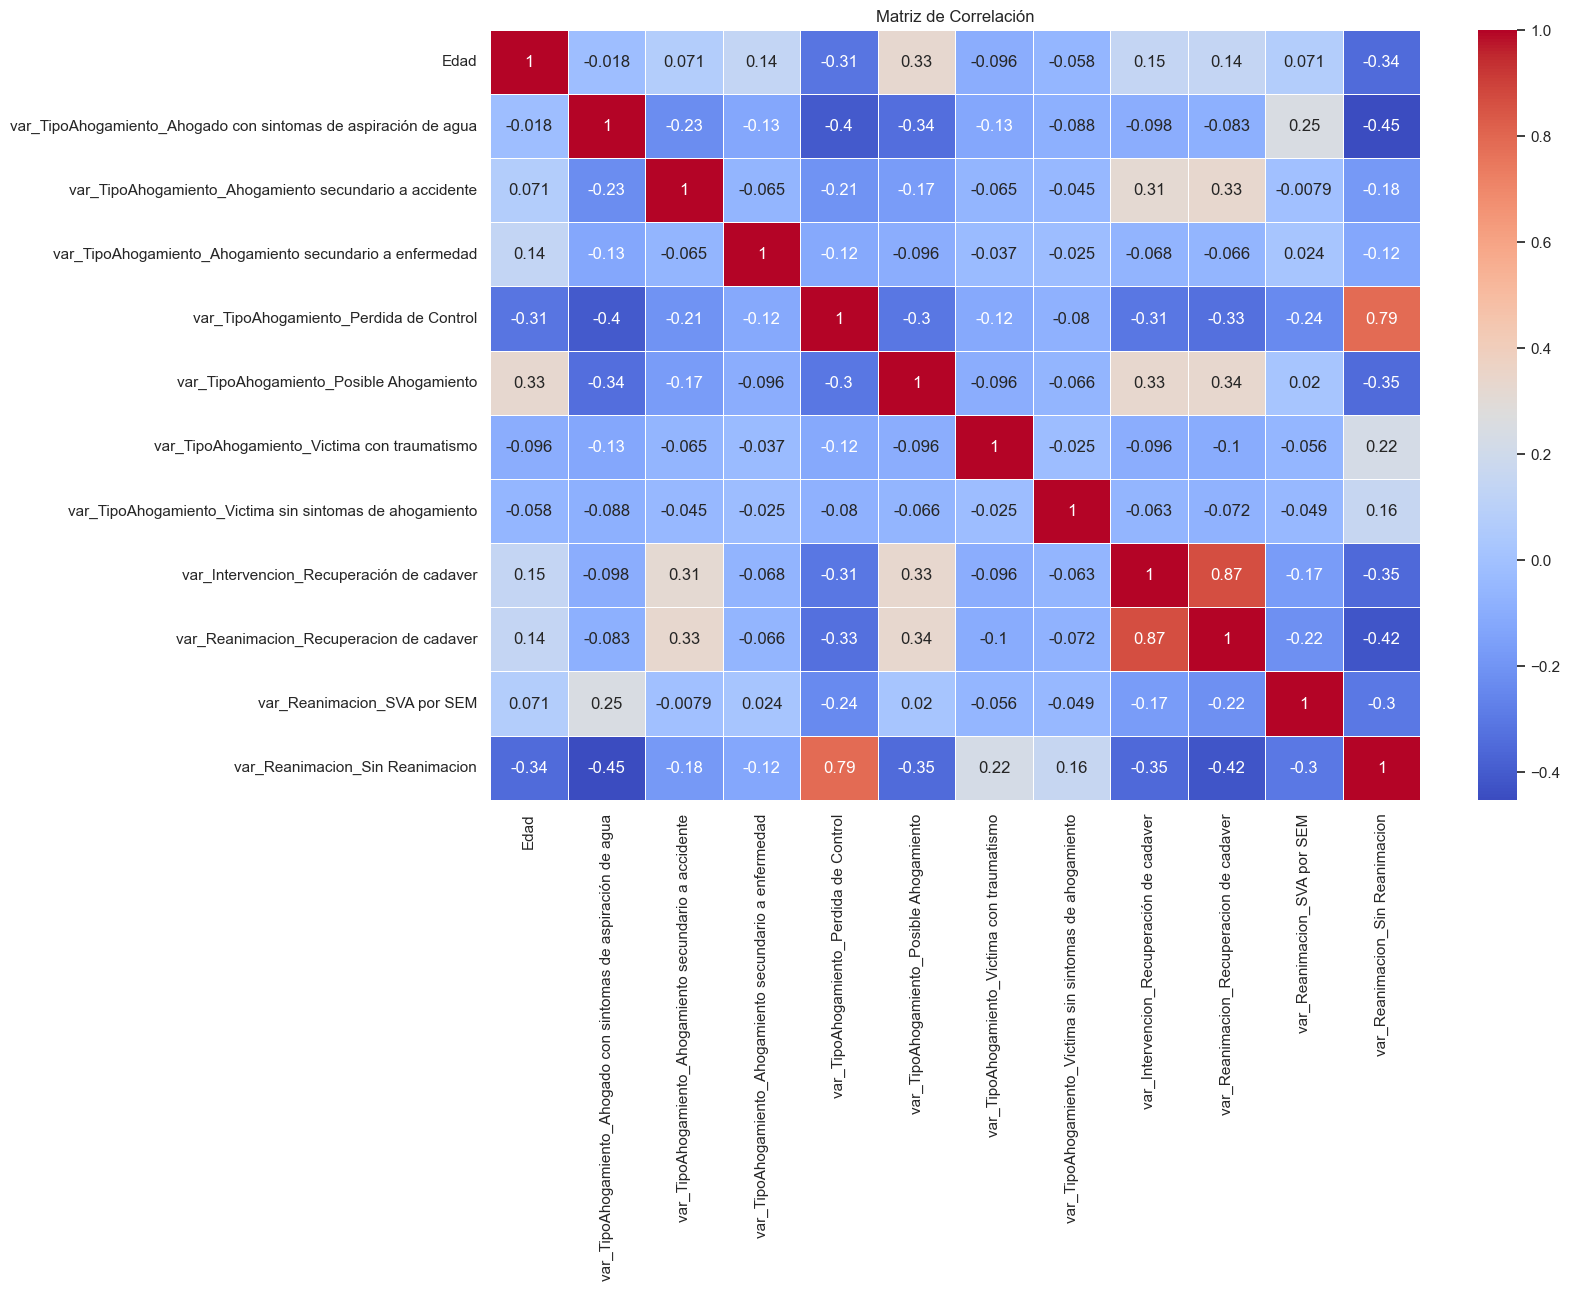

In [215]:
# Calculo de la matriz de correlación
corr_matrix = X.corr()

# Crea un mapa de calor de la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

+ La correlación alta (positiva o negativa) entre dos o más variables indica una posible multicolinealidad. Se puede visualizar la matriz de correlación utilizando un mapa de calor.

In [216]:
# Análisis de valores propios
eigenvalues = np.linalg.eigvals(corr_matrix)
eigenvalues

array([3.08806151, 1.9755382 , 0.03532188, 0.09647457, 0.14504714,
       0.48644338, 1.31178165, 0.72982384, 0.92146152, 1.11122492,
       1.07625939, 1.02256201])

+ Podemos realizar un análisis de valores propios (Eigenvalues) de la matriz de correlación. Si uno o más valores propios son cercanos a cero, indica una posible multicolinealidad. Un eigenvalue alto indica que una gran cantidad de varianza está siendo explicada por las variables en el conjunto, lo que sugiere una baja multicolinealidad. Por otro lado, un eigenvalue cercano a cero indica que hay una alta cantidad de varianza no explicada por las variables, lo que sugiere una posible presencia de multicolinealidad.

## <span style=color:darkblue>Selección de las variables que son significativas</span>

In [217]:
# Seleccionamos las variables que finalmente son candidatas para nuestro modelo
columns_excluded = [11] # Eliminamos 'var_Reanimacion_Sin Reanimacion', altamente correlacionado y VIF alto
X_selected = X.drop(X.columns[columns_excluded], axis = 1)
X_selected.head(3)

,Edad,var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua,var_TipoAhogamiento_Ahogamiento secundario a accidente,var_TipoAhogamiento_Ahogamiento secundario a enfermedad,var_TipoAhogamiento_Perdida de Control,var_TipoAhogamiento_Posible Ahogamiento,var_TipoAhogamiento_Victima con traumatismo,var_TipoAhogamiento_Victima sin sintomas de ahogamiento,var_Intervencion_Recuperación de cadaver,var_Reanimacion_Recuperacion de cadaver,var_Reanimacion_SVA por SEM
2,0.484211,0,1,0,0,0,0,0,1,1,0
3,0.336842,0,0,0,1,0,0,0,1,0,0
5,0.652632,0,1,0,0,0,0,0,0,0,1


In [218]:
# Analizamos los resultados
logit_model = sm.Logit(y, X_selected)
result = logit_model.fit(method = 'lbfgs')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.33856D-01

At iterate    1    f=  5.14828D-01    |proj g|=  1.01472D-01

At iterate    2    f=  3.78484D-01    |proj g|=  3.73617D-02

At iterate    3    f=  3.36484D-01    |proj g|=  1.78765D-02

At iterate    4    f=  3.10046D-01    |proj g|=  7.73516D-03

At iterate    5    f=  3.08597D-01    |proj g|=  3.88518D-02

At iterate    6    f=  2.94225D-01    |proj g|=  6.61523D-03

At iterate    7    f=  2.92076D-01    |proj g|=  2.27872D-03

At iterate    8    f=  2.90628D-01    |proj g|=  2.30731D-03

At iterate    9    f=  2.88581D-01    |proj g|=  2.05401D-03

At iterate   10    f=  2.87510D-01    |proj g|=  2.23005D-03

At iterate   11    f=  2.87278D-01    |proj g|=  6.94504D-04

At iterate   12    f=  2.87241D-01    |proj g|=  4.26311D-04

At iterate   13    f=  2.8

 This problem is unconstrained.


In [219]:
# Resumen
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: Logit
===============================================================================================================
Model:                              Logit                            Method:                          MLE      
Dependent Variable:                 AhogamientoMortal                Pseudo R-squared:                0.586    
Date:                               2023-06-28 07:40                 AIC:                             3715.5649
No. Observations:                   6436                             BIC:                             3790.0312
Df Model:                           10                               Log-Likelihood:                  -1846.8  
Df Residuals:                       6425                             LL-Null:                         -4461.0  
Converged:                          1.0000                           LLR p-value:                     0.0000   
No. Iterations:                     34.0000                          Scale:                           1.0000   
---------------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------
Edad                                                            0.4517   0.1439   3.1386 0.0017  0.1696  0.7337
var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua -0.2053   0.0875  -2.3461 0.0190 -0.3768 -0.0338
var_TipoAhogamiento_Ahogamiento secundario a accidente         -0.1128   0.1598  -0.7058 0.4803 -0.4259  0.2004
var_TipoAhogamiento_Ahogamiento secundario a enfermedad         0.4669   0.1801   2.5923 0.0095  0.1139  0.8198
var_TipoAhogamiento_Perdida de Control                         -6.5087   0.5265 -12.3631 0.0000 -7.5406 -5.4769
var_TipoAhogamiento_Posible Ahogamiento                         0.9017   0.1445   6.2384 0.0000  0.6184  1.1850
var_TipoAhogamiento_Victima con traumatismo                    -4.2365   0.4914  -8.6218 0.0000 -5.1996 -3.2734
var_TipoAhogamiento_Victima sin sintomas de ahogamiento        -5.0181   1.0129  -4.9540 0.0000 -7.0034 -3.0328
var_Intervencion_Recuperación de cadaver                        2.0228   0.3336   6.0632 0.0000  1.3689  2.6767
var_Reanimacion_Recuperacion de cadaver                         3.7526   0.4427   8.4765 0.0000  2.8849  4.6203
var_Reanimacion_SVA por SEM                                     0.6965   0.0925   7.5310 0.0000  0.5152  0.8777
===============================================================================================================

"""

In [220]:
# Calculo del VIF
vif = pd.DataFrame()
vif["Variable"] = X_selected.columns
vif["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
vif

,Variable,VIF
0,Edad,4.897087
1,var_TipoAhogamiento_Ahogado con sintomas de as...,2.568335
2,var_TipoAhogamiento_Ahogamiento secundario a a...,2.008227
3,var_TipoAhogamiento_Ahogamiento secundario a e...,1.282031
4,var_TipoAhogamiento_Perdida de Control,1.520461
5,var_TipoAhogamiento_Posible Ahogamiento,3.131904
6,var_TipoAhogamiento_Victima con traumatismo,1.070203
7,var_TipoAhogamiento_Victima sin sintomas de ah...,1.036709
8,var_Intervencion_Recuperación de cadaver,5.289390
9,var_Reanimacion_Recuperacion de cadaver,5.777518


+ Obtenemos un valor de VIF por debajo de 5 en cada una de las variables.

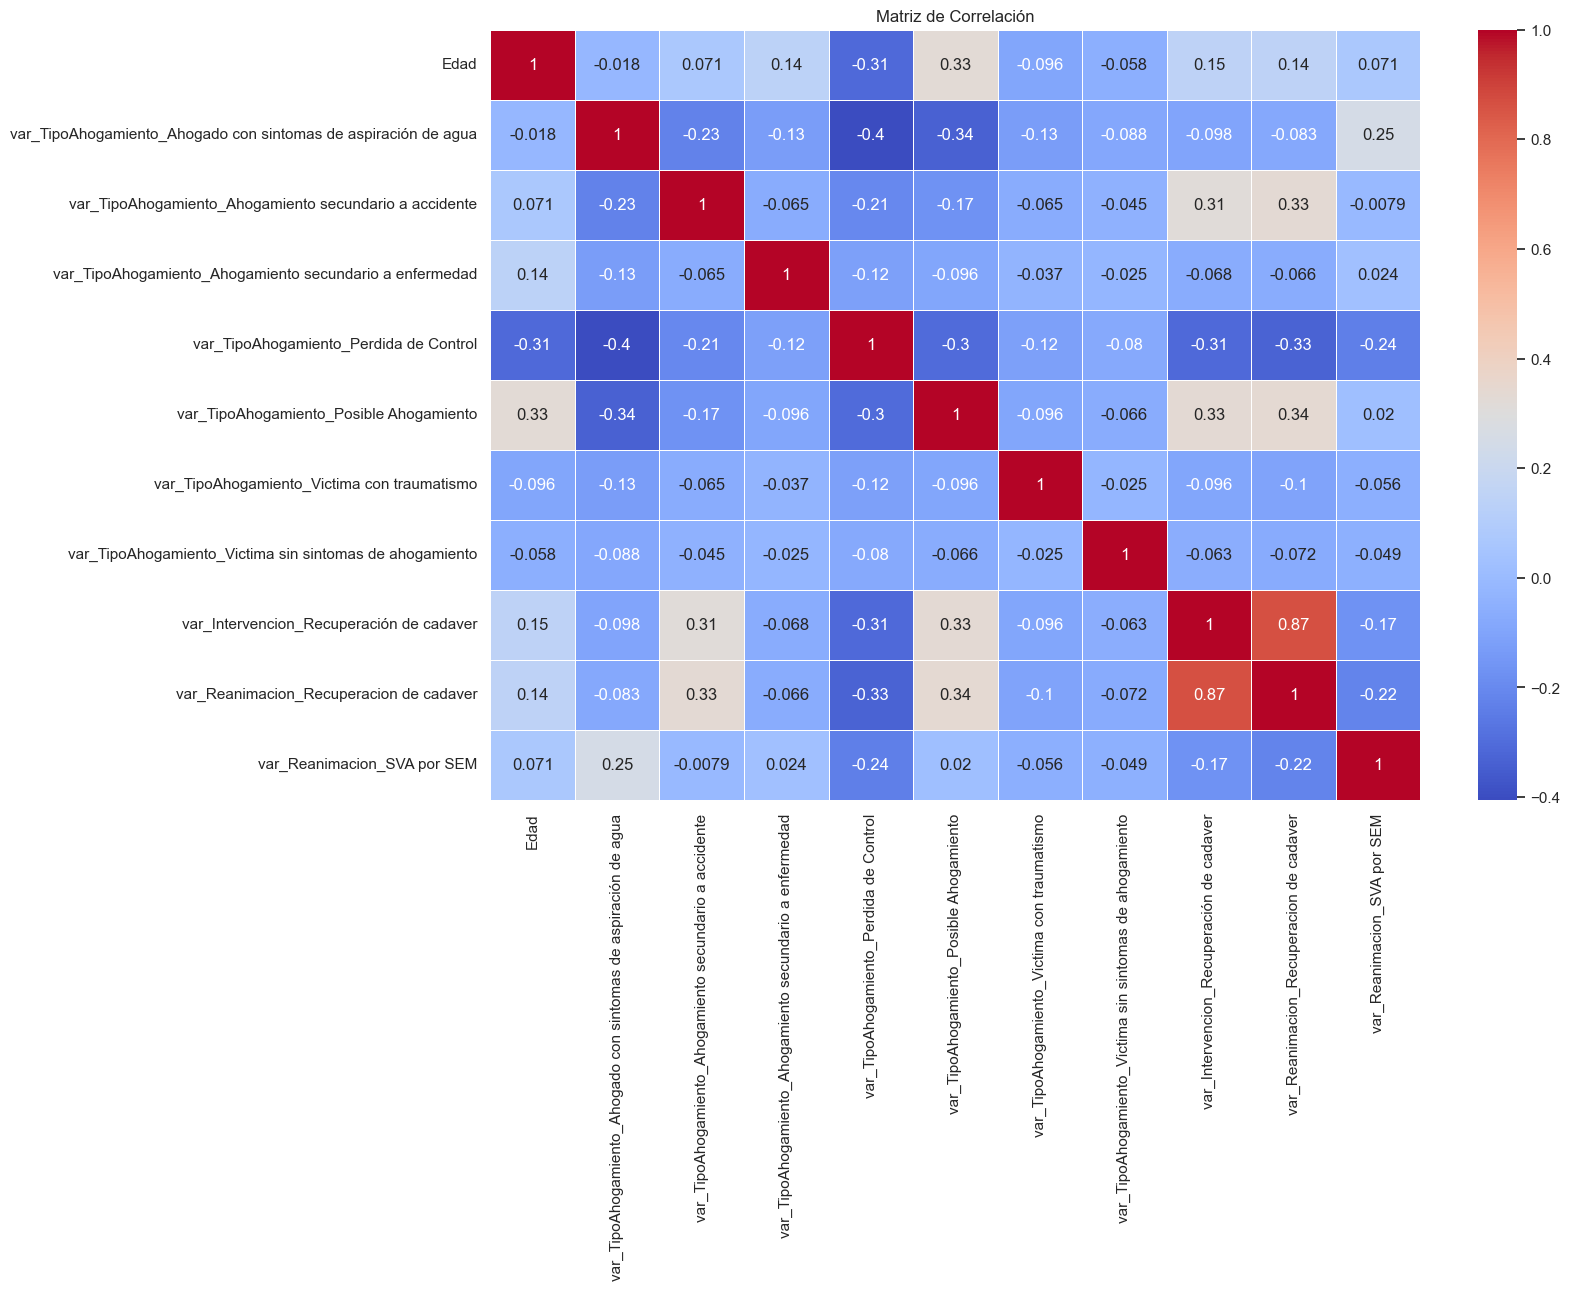

In [221]:
# Calculo de la matriz de correlación
corr_matrix = X_selected.corr()

# Crea un mapa de calor de la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

+ No hay variables correlacioandas entre ellas.

## <span style=color:darkblue>Model Fitting</span>

In [222]:
# Aplicamos el modelo de Regresión Logística sobre los datos que son relevantes para explicar el ahogamiento mortal 
X_train, X_test, y_train, y_test = train_test_split(X_selected, np.ravel(y), test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [223]:
# Realizamos predicciones del modelo sobre los datos de test
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


In [224]:
# Creamos la matriz de confusión para analizar los aciertos y errores
confusion_matrix = confusion_matrix(y_test, y_pred)

<AxesSubplot: >

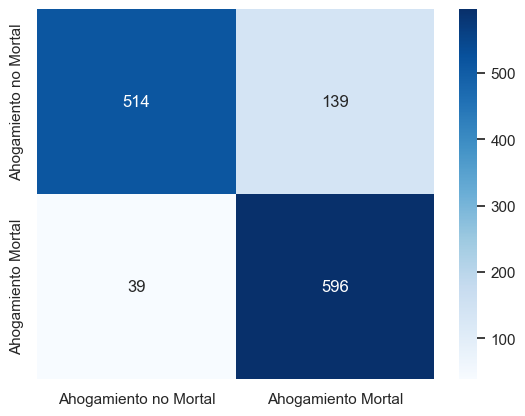

In [225]:
# Definimos las etiquetas de las clases
class_labels = ['Ahogamiento no Mortal', 'Ahogamiento Mortal']

# Plot de la matriz de confusión utilizando seaborn
sns.heatmap(confusion_matrix, annot=True, cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, fmt='d', annot_kws={"fontsize": 12})

In [226]:
# Analizamos con más detalle las diferentes métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85       653
           1       0.81      0.94      0.87       635

    accuracy                           0.86      1288
   macro avg       0.87      0.86      0.86      1288
weighted avg       0.87      0.86      0.86      1288



+ Podemos ver como la precisión para detectar un ahogamiento como no mortales del 93% (514 / (514 + 39)), mientras que la precisión para detectar un ahogamiento como mortal es del 81% (596 / (596 + 139)).

+ El recall es la capacidad del clasificador para encontrar todas las muestras positivas o negativas. Para el recuento de todos los ahogamientos no mortales, el algoritmo es capaz de clasificar correctamente el 79% de las obaservaciones, mientras que para el recuento de todos los ahogamientos mortales es capaz de clasificar correctamente el 94% de las veces. 

+ La puntuación F-score es una media armónica ponderada de la precisión y el recall, donde cuánto más próxima a 1 mejor. Y podemos observar que se encuentra en ambos casos cerca de 1.

+ Podemos concluir que es un buen algoritmo para predecir si un ahogamiento es mortal o no.

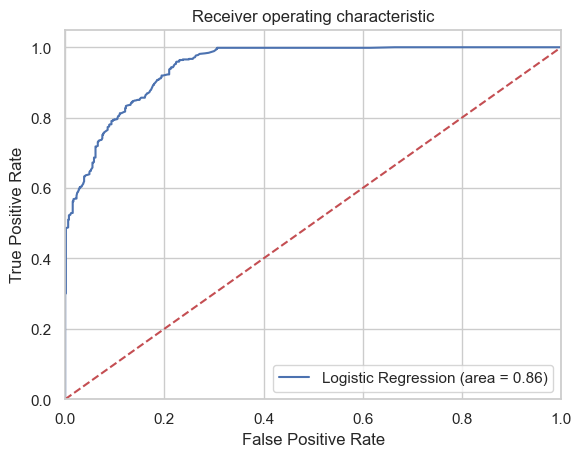

In [227]:
# Curva ROC
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

+ La interpretación de la curva ROC se basa en la relación entre la TPR y el FPR. La curva ROC muestra cómo varía esta relación a través de diferentes niveles de umbral.

+ Una curva ROC ideal se acerca al vértice superior izquierdo del gráfico, lo que indica una alta TPR y un bajo FPR en todos los niveles de umbral como es nuestro caso. Cuanto más alejada esté la curva ROC de la línea de referencia diagonal (que representa el desempeño aleatorio), mejor será el desempeño del modelo. 

In [228]:
X_train.columns

Index(['Edad',
       'var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua',
       'var_TipoAhogamiento_Ahogamiento secundario a accidente',
       'var_TipoAhogamiento_Ahogamiento secundario a enfermedad',
       'var_TipoAhogamiento_Perdida de Control',
       'var_TipoAhogamiento_Posible Ahogamiento',
       'var_TipoAhogamiento_Victima con traumatismo',
       'var_TipoAhogamiento_Victima sin sintomas de ahogamiento',
       'var_Intervencion_Recuperación de cadaver',
       'var_Reanimacion_Recuperacion de cadaver',
       'var_Reanimacion_SVA por SEM'],
      dtype='object')

# <span style=color:darkblue>CLASSIFICATION 2 (Binary Logistic Regression)</span>

In [237]:
# Carga de los datos
pd.set_option('display.max_columns', None)
ahogamientos = pd.read_csv("/Users/adrianova/Desktop/git/TFM - Notebooks/datos_ahogamiento_meteorologicos2.csv",  encoding='utf-8')
ahogamientos.head(2)

,Fecha,IdAhogado,IdPersona,Localidad,Provincia,CCAA,Hora,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Titular,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Riesgo,Reanimacion,Vigilancia,Actividad,Deteccion,Enlace1,Indicador,Estacion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,30-12-2020,7432,8532,Torredembarra,Tarragona,Cataluña,NaN,41.130523,1.395311,NaN,NaN,España,NaN,Embarcación de rescate,Encuentran un cadáver flotando en el mar cerca...,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,NaN,Recuperacion de cadaver,No vigilado,NaN,Ciudadano,#https://www.diarimes.com/es/noticias/camp_tar...,9981A,ESTACIÓN DE TORTOSA (ROQUETES),50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,29-12-2020,7431,8531,"Cádiz, Playa de Santa Maria del Mar",Cádiz,Andalucía,17:48,36.519991,-6.287258,NaN,NaN,España,NaN,Ciudadano,Evacuada al hospital en estado grave una perso...,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,NaN,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,#https://elcorreoweb.es/andalucia/encuentran-u...,5973,CÁDIZ,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,NaN,1017.0,1011.4


In [238]:
# 8015 observaciones y 40 columnas
ahogamientos.shape

(8015, 40)

## <span style=color:darkblue>Limpieza de los datos</span>

+ Hay columnas que de por si no son relevantes a la hora de aplicar algoritmos de aprendizaje automático como lo son los identificadores o variables que son explicadas por otras:

    - **IdAhogado:** es un identificador
    - **IdPersona:** es un identificador
    - **Indicador:** es un identificador 
    - **Localidad:** queda explicada por CCAA y con menos categorías
    - **Provincia:** queda explicada por CCAA y con menos categorías
    - **Fecha, Hora, Titular, Enlace1, Estación**: no aporta información al modelo

In [239]:
# Eliminamos las columnas que estamos 100% seguros que no aportan valor
ahogamientos_df = ahogamientos.copy()
ahogamientos_df.drop(["IdAhogado", "IdPersona","Indicador", "Localidad", \
                      "Provincia", "Fecha", "Hora", "Titular", "Enlace1", "Estacion"], axis = 1, inplace = True)
ahogamientos_df.head(2)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Origen,Extraccion,Causa,TipoAhogamiento,Factor,Intervencion,Pronostico,Localizacion,Riesgo,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin
0,Cataluña,41.130523,1.395311,NaN,NaN,España,NaN,Embarcación de rescate,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,NaN,Recuperacion de cadaver,No vigilado,NaN,Ciudadano,50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9
1,Andalucía,36.519991,-6.287258,NaN,NaN,España,NaN,Ciudadano,NaN,Posible Ahogamiento,NaN,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,NaN,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,NaN,1017.0,1011.4


In [240]:
# 8015 observaciones y 30 columnas
ahogamientos_df.shape

(8015, 30)

+ De las variables restantes pueden haber algunas más interesantes que otras para el modelo de clasificación. Para ello es importante conocer los valores faltantes que nos puede ayudar a determinar que variables son relevantes y cuáles no.

In [241]:
round(ahogamientos_df.isna().sum()/ahogamientos_df.shape[0],4) * 100

CCAA                0.00
Latitud             0.00
Longitud            0.00
Sexo                4.97
Edad               19.70
Nacionalidad        1.16
Origen             43.87
Extraccion          1.32
Causa              28.10
TipoAhogamiento     0.30
Factor             58.22
Intervencion        0.97
Pronostico          0.26
Localizacion        0.00
Riesgo             61.37
Reanimacion         2.83
Vigilancia          0.34
Actividad           4.15
Deteccion           1.71
Altitud             0.00
TempMed             0.42
Precip              4.63
TempMin             0.42
TempMax             0.36
DirViento           2.28
VelMedViento        2.01
RachaViento         2.28
TiempoSol           7.70
PresionMax          0.71
PresionMin          0.70
dtype: float64

+ Hay ciertas variables que pueden ser importantes para revelar patrones de comportamiento como lo son el origen, la causa, el factor y el riesgo de ahogamiento pero que mantienen demasiados valores faltantes y que para esta aproximación nos desharemos de ellas, excepto la variable causa. 


+ Por otro lado, la variable edad tiene aproximadamente un 20% de valores faltantes, y para esta aproximación imputaremos los valores con su media. 


+ Para las variables categóricas realizaremos imputación de missings con la moda, ya que el número de valores faltantes es muy bajo.


+ Para las variables meteorológicas realizaremos imputación de missings sobre la mediana, ya que el número de valores faltantes es muy bajo.

In [242]:
# Realizamos imputación de missings sobre la variable edad con la mediana
ahogamientos_df["Edad"] = ahogamientos_df["Edad"].fillna(ahogamientos_df["Edad"].median())

In [243]:
# Primera prueba eliminando ORIGEN, CAUSA, FACTOR Y RIESGO
ahogamientos_df.drop(["Origen",'Factor', "Riesgo"], axis = 1, inplace = True)

In [244]:
# Imputación de missings con el valor más frecuente
no_data_columns = ["Sexo", "Nacionalidad", "Extraccion", "TipoAhogamiento", "Causa", "Intervencion", "Pronostico", "Reanimacion", "Vigilancia", "Actividad", "Deteccion"]
      
for var in no_data_columns:
    moda = ahogamientos_df[var].mode().iloc[0]
    ahogamientos_df[var] = ahogamientos_df[var].fillna(moda)

In [245]:
# Realizamos imputación de missings sobre las variables meteorologicas
median_imputation = ["TempMed", "Precip", "TempMin", "TempMax", "DirViento",\
"VelMedViento", "RachaViento","TiempoSol", "PresionMax", "PresionMin"]

# Calculo de la mediana de cada variable
medians = ahogamientos_df[median_imputation].median()

for median in median_imputation:
    ahogamientos_df[median] = ahogamientos_df[median].fillna(medians[median])

In [246]:
# Mantenemos 8015 observaciones, pero 27 columnas
ahogamientos_df.shape

(8015, 27)

+ Creamos una variable adicional que determinará si un ahogamiento ha sido mortal (1) de uno que no lo ha sido (0) a partir de la variable **Pronóstico** dentro del dataset de ahogamientos.

In [247]:
# Creamos variable fictícia si se ha producido ahogamiento 1 o no 0
ahogamientos_df["AhogamientoMortal"] = np.where(ahogamientos_df["Pronostico"] == "Ahogamiento mortal", 1, 0)                                                                                                                                                                  
ahogamientos_df.head(2)

,CCAA,Latitud,Longitud,Sexo,Edad,Nacionalidad,Extraccion,Causa,TipoAhogamiento,Intervencion,Pronostico,Localizacion,Reanimacion,Vigilancia,Actividad,Deteccion,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin,AhogamientoMortal
0,Cataluña,41.130523,1.395311,Hombre,46.0,España,Embarcación de rescate,Condiciones del medio acuático,Posible Ahogamiento,Recuperación de cadaver,Ahogamiento mortal,Franja costera o alta mar,Recuperacion de cadaver,No vigilado,Natación recreativa,Ciudadano,50,10.0,0.0,8.0,12.1,30.0,4.4,22.8,3.9,1010.0,1000.9,1
1,Andalucía,36.519991,-6.287258,Hombre,46.0,España,Ciudadano,Condiciones del medio acuático,Posible Ahogamiento,Recuperación de cadaver,Ahogamiento no mortal con hospitalizacion,Playas sin vigilancia,SVA por SEM,No vigilado,Natación recreativa,Ciudadano,2,12.2,0.2,9.2,15.3,32.0,3.3,9.4,9.6,1017.0,1011.4,0


In [248]:
# Eliminamos las variables Longitud y Latitud, ya que son variables que no aportan información sobre nuestro modelo
ahogamientos_df = ahogamientos_df.drop(['Latitud', 'Longitud'], axis=1)

In [249]:
# 6436 observaciones y 26 columnas
ahogamientos_df.shape

(8015, 26)

## <span style=color:darkblue>Selección de variables para el modelo</span>

0    4546
1    3469
Name: AhogamientoMortal, dtype: int64


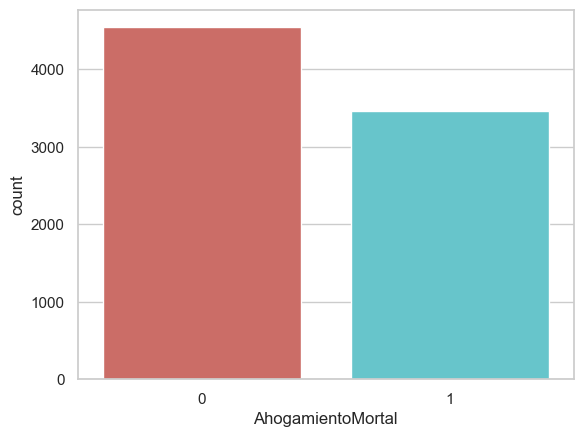

In [250]:
# observamos la distribución de la variable ahogamiento mortal
print(ahogamientos_df['AhogamientoMortal'].value_counts())

# Plot
sns.countplot(x = 'AhogamientoMortal', data = ahogamientos_df, palette = 'hls')
plt.show()

+ En comparativa con el primer modelo de clasificación en el que nos deshicimos del 20% de valores faltantes de la variable edad y no introducimos la variable causa dentro de nuestro modelo, vemos que hay un mayor número de valores de ahogamientos no mortales, respecto a ahogamientos mortales. 

## <span style=color:darkblue>Dummies sobre las variables categóricas</span>

In [251]:
# Variables categoricas. Aplicación de la técnica dummies sobre las variables categóricas
cat_vars = list(ahogamientos_df.select_dtypes('object').columns)

for var in cat_vars:
    cat_list = 'var' + '_' + var
    cat_list = pd.get_dummies(ahogamientos_df[var], prefix = cat_list)
    ahogamientos_df_1 = ahogamientos_df.join(cat_list)
    ahogamientos_df = ahogamientos_df_1
    
    
cat_vars = list(ahogamientos_df.select_dtypes('object').columns)
data_vars = ahogamientos_df.columns.values.tolist()
to_keep = [i for i in data_vars if i not in cat_vars]

In [252]:
# Aplicamos dummies sobre el dataframe original
ahogamientos_df_final = ahogamientos_df[to_keep]

In [253]:
# Dataframe final con variables numéricas y categóricas (dummies)
ahogamientos_df_final.head(3)

,Edad,Altitud,TempMed,Precip,TempMin,TempMax,DirViento,VelMedViento,RachaViento,TiempoSol,PresionMax,PresionMin,AhogamientoMortal,var_CCAA_Andalucía,var_CCAA_Aragón,var_CCAA_Asturias,var_CCAA_Canarias,var_CCAA_Cantabria,var_CCAA_Castilla La Mancha,var_CCAA_Castilla y León,var_CCAA_Cataluña,var_CCAA_Ceuta,var_CCAA_Ciudad Valenciana,var_CCAA_Extremadura,var_CCAA_Galicia,var_CCAA_Islas Baleares,var_CCAA_La Rioja,var_CCAA_Madrid,var_CCAA_Melilla,var_CCAA_Murcia,var_CCAA_Navarra,var_CCAA_País Vasco,var_Sexo_Hombre,var_Sexo_Mujer,var_Nacionalidad_España,var_Nacionalidad_Otro,"var_Extraccion_Acompañante, familiar, amigo",var_Extraccion_Ciudadano,var_Extraccion_Cuerpo de Seguridad o Emergencias,var_Extraccion_Embarcacion costera,var_Extraccion_Embarcación de recreo,var_Extraccion_Embarcación de rescate,var_Extraccion_Fuerzas orden publico,var_Extraccion_Helicoptero,var_Extraccion_Moto acuática de rescate,var_Extraccion_No preciso extraccion,var_Extraccion_Otros,var_Extraccion_Socorrista,var_Extraccion_Socorrista con material,var_Extraccion_Tabla de rescate,var_Causa_Accidente de Trafico,"var_Causa_Accidente, caída o zambullida accidentales",var_Causa_Atrapamiento,var_Causa_Condiciones del medio acuático,var_Causa_Corriente de resaca,"var_Causa_Drogas, alcohol, otros tóxicos","var_Causa_Enfermedad, ataque cardíaco o ACVA",var_Causa_Excesiva confianza o asunción de riesgo,var_Causa_Falta de competencia acuática,var_Causa_Falta de supervisión o vigilancia,"var_Causa_Homicidio, Asesinato",var_Causa_Incidente o accidente de buceo,var_Causa_Intento de rescate de personas o animales,var_Causa_Naufragio,var_Causa_Navegación o deportes acuáticos,var_Causa_Otros,"var_Causa_Riadas, desbordamientos, inundaciones",var_Causa_Suicidio,var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua,var_TipoAhogamiento_Ahogado por hidrocucion,var_TipoAhogamiento_Ahogado sin sintomas de aspiración de agua,var_TipoAhogamiento_Ahogamiento secundario a accidente,var_TipoAhogamiento_Ahogamiento secundario a enfermedad,var_TipoAhogamiento_Distres Acuatico,var_TipoAhogamiento_Muerte previa a inmersion,var_TipoAhogamiento_Perdida de Control,var_TipoAhogamiento_Posible Ahogamiento,var_TipoAhogamiento_Victima con traumatismo,var_TipoAhogamiento_Victima sin sintomas de ahogamiento,var_Intervencion_Asistencia por transeúntes adiestrados,var_Intervencion_Asistencia por transeúntes no adiestrados,var_Intervencion_Recuperación de cadaver,var_Intervencion_Rescate por Socorristas o personas adiestradas en RCP,var_Intervencion_Rescate por personal adiestrado con equipamiento,var_Intervencion_Rescate por personal adiestrado con soporte de emergencias,var_Intervencion_Rescate y atención in situ por personal de salvamento y emergencias,var_Intervencion_Rescate y atención médica completa,var_Pronostico_Ahogamiento mortal,var_Pronostico_Ahogamiento no mortal con hospitalizacion,var_Pronostico_Fallecimiento Sin Ahogamiento,var_Pronostico_Lesiones,var_Pronostico_Rescate con necesidad de observación posterior,var_Pronostico_Rescate sin consecuencias,var_Pronostico_Rescate y traslado a supervisión médica,var_Pronostico_Traumatismo/TRM,var_Localizacion_Aguas interiores con vigilancia,var_Localizacion_Aguas interiores sin vigilancia,var_Localizacion_Bañera,"var_Localizacion_Contenedor de agua, cubo, fuente, etc","var_Localizacion_Embalses, Pantanos",var_Localizacion_Entorno marino,var_Localizacion_Franja costera o alta mar,var_Localizacion_Otros,var_Localizacion_Parque acuatico,var_Localizacion_Piscinas de equipamientos hoteleros y similares,var_Localizacion_Piscinas de urbanizaciones con vigilancia,var_Localizacion_Piscinas domesticas no vigiladas,var_Localizacion_Piscinas publicas con vigilancia,var_Localizacion_Piscinas urbanización o privadas no vigiladas,var_Localizacion_Playas con vigilancia,var_Localizacion_Playas sin vigilancia,"var_Localizacion_Puertos, embarcaderos, amarres","var_Localizacion_Rios, canales y similares","var_Localizacion_Sistemas de recogida, transporte o

In [254]:
# 8015 observaciones y 161 columnas
ahogamientos_df_final.shape

(8015, 161)

## <span style=color:darkblue>Eliminación de variables de forma recursiva (RFE)</span>

+ La idea general del método RFE es poder seleccionar aquellas variables que son más relevantes para explicar que un ahogamiento mortal de uno que no lo es. Primeramente se hace una criba de todas aquellas variables que no aportan información directa.

In [255]:
# Separamos la variable dependiente (Ahogamiento Mortal) de la variable independiente
X = ahogamientos_df_final.loc[:, ahogamientos_df_final.columns != 'AhogamientoMortal']
y = ahogamientos_df_final.loc[:, ahogamientos_df_final.columns == 'AhogamientoMortal']

In [256]:
####################### SCALING ########################################

# Seleccionar solo las columnas numéricas
num_cols = X.iloc[:, :12].columns

# Normalizar las columnas numéricas
scaler = MinMaxScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

#################### MODEL ########################################
# Model
logreg = LogisticRegression()

rfe = RFE(estimator = logreg, n_features_to_select = 20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/var/folders/f4/f_hhbl4s7hb5ldn8l8lf6kzr0000gn/T/ipykernel_5449/3339871855.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False  True  True
 False  True  True  True  True  True False False  True False False False
 False False  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[  1  32  80 140  25 123 

In [257]:
# Veamos las variables que han sido seleccionadas
feature_names = X.columns
selected_features = feature_names[rfe.support_]
selected_features

Index(['Edad',
       'var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua',
       'var_TipoAhogamiento_Ahogamiento secundario a accidente',
       'var_TipoAhogamiento_Ahogamiento secundario a enfermedad',
       'var_TipoAhogamiento_Muerte previa a inmersion',
       'var_TipoAhogamiento_Perdida de Control',
       'var_TipoAhogamiento_Posible Ahogamiento',
       'var_TipoAhogamiento_Victima con traumatismo',
       'var_TipoAhogamiento_Victima sin sintomas de ahogamiento',
       'var_Intervencion_Recuperación de cadaver',
       'var_Pronostico_Ahogamiento mortal',
       'var_Pronostico_Ahogamiento no mortal con hospitalizacion',
       'var_Pronostico_Fallecimiento Sin Ahogamiento',
       'var_Pronostico_Lesiones',
       'var_Pronostico_Rescate con necesidad de observación posterior',
       'var_Pronostico_Rescate sin consecuencias',
       'var_Pronostico_Rescate y traslado a supervisión médica',
       'var_Pronostico_Traumatismo/TRM',
       'var_Reanimacion_Re

In [258]:
# Columnas sin tener en cuenta la variable Pronostico
columnas_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 19]
selected_features = [selected_features[i] for i in columnas_indices]

In [259]:
# Seleccionamos las columnas para implementarlas en el modelo
X = X[selected_features]
y = y

## <span style=color:darkblue>Implementing the model</span>

In [260]:
# Aplicamos el logaritmo Logit
logit_model = sm.Logit(y, X)
result = logit_model.fit(method = 'lbfgs')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.12601D-01

At iterate    1    f=  4.52821D-01    |proj g|=  1.03884D-01

At iterate    2    f=  3.14492D-01    |proj g|=  4.51788D-02

At iterate    3    f=  2.76805D-01    |proj g|=  2.02818D-02

At iterate    4    f=  2.58177D-01    |proj g|=  8.99573D-03

At iterate    5    f=  2.51276D-01    |proj g|=  8.10932D-03

At iterate    6    f=  2.47915D-01    |proj g|=  6.22248D-03

At iterate    7    f=  2.46894D-01    |proj g|=  1.72688D-03

At iterate    8    f=  2.46259D-01    |proj g|=  2.24344D-03

At iterate    9    f=  2.45730D-01    |proj g|=  2.26338D-03

At iterate   10    f=  2.44630D-01    |proj g|=  1.88151D-03

At iterate   11    f=  2.44221D-01    |proj g|=  2.25668D-03

At iterate   12    f=  2.43796D-01    |proj g|=  1.15108D-03

At iterate   13    f=  2.4

 This problem is unconstrained.
/Users/adrianova/mambaforge/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [261]:
# Observamos como la mayoría de p-values son inferiores a 0.05
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: Logit
===============================================================================================================
Model:                              Logit                            Method:                          MLE      
Dependent Variable:                 AhogamientoMortal                Pseudo R-squared:                0.648    
Date:                               2023-06-28 07:49                 AIC:                             3880.7510
No. Observations:                   8015                             BIC:                             3964.6199
Df Model:                           11                               Log-Likelihood:                  -1928.4  
Df Residuals:                       8003                             LL-Null:                         -5483.0  
Converged:                          0.0000                           LLR p-value:                     0.0000   
No. Iterations:                     35.0000                          Scale:                           1.0000   
---------------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------
Edad                                                            0.8482   0.1492   5.6861 0.0000  0.5558  1.1406
var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua -0.1484   0.0835  -1.7770 0.0756 -0.3120  0.0153
var_TipoAhogamiento_Ahogamiento secundario a accidente          0.4912   0.1691   2.9050 0.0037  0.1598  0.8227
var_TipoAhogamiento_Ahogamiento secundario a enfermedad         0.3822   0.1772   2.1575 0.0310  0.0350  0.7294
var_TipoAhogamiento_Muerte previa a inmersion                  -7.5183   0.9636  -7.8025 0.0000 -9.4069 -5.6297
var_TipoAhogamiento_Perdida de Control                         -3.6718   0.3385 -10.8465 0.0000 -4.3353 -3.0083
var_TipoAhogamiento_Posible Ahogamiento                         0.9008   0.1413   6.3770 0.0000  0.6239  1.1776
var_TipoAhogamiento_Victima con traumatismo                    -1.9480   0.4085  -4.7686 0.0000 -2.7486 -1.1473
var_TipoAhogamiento_Victima sin sintomas de ahogamiento        -3.7222   1.0649  -3.4952 0.0005 -5.8094 -1.6350
var_Intervencion_Recuperación de cadaver                        3.2224   0.3128  10.3032 0.0000  2.6094  3.8354
var_Reanimacion_Recuperacion de cadaver                         3.5868   0.5428   6.6082 0.0000  2.5230  4.6507
var_Reanimacion_Sin Reanimacion                                -2.5161   0.1619 -15.5415 0.0000 -2.8334 -2.1988
===============================================================================================================

"""

+ Todas las variables predictoras que aparece en el modelo resultan relevante para explicar que un ahogamiento es mortal, si tuvieramos que descartar alguna seria **'var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua'**.

In [262]:
# Calculo del VIF. Miramos la multicolinealidad
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Variable,VIF
0,Edad,5.557153
1,var_TipoAhogamiento_Ahogado con sintomas de as...,2.240116
2,var_TipoAhogamiento_Ahogamiento secundario a a...,1.924049
3,var_TipoAhogamiento_Ahogamiento secundario a e...,1.257362
4,var_TipoAhogamiento_Muerte previa a inmersion,1.023783
5,var_TipoAhogamiento_Perdida de Control,8.458788
6,var_TipoAhogamiento_Posible Ahogamiento,2.966745
7,var_TipoAhogamiento_Victima con traumatismo,1.632109
8,var_TipoAhogamiento_Victima sin sintomas de ah...,1.473280
9,var_Intervencion_Recuperación de cadaver,5.296337


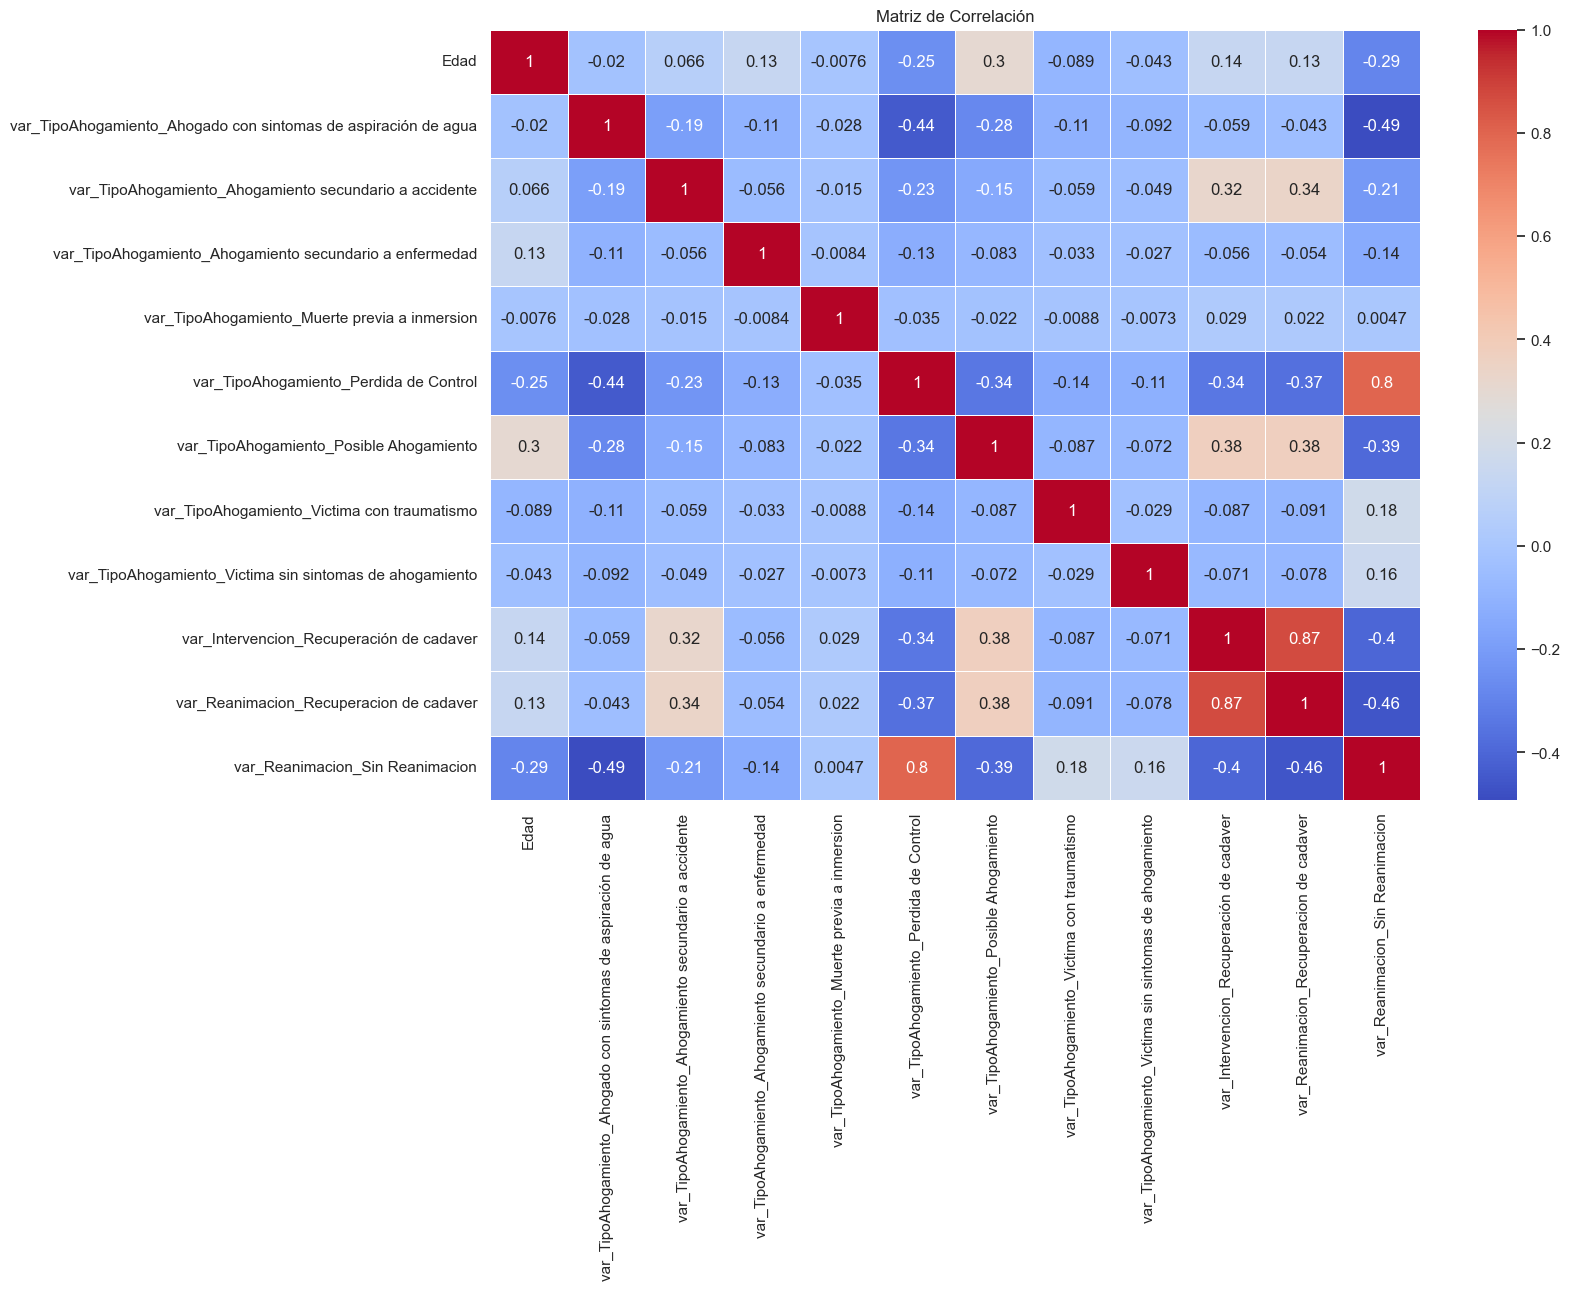

In [263]:
# Calculo de la matriz de correlación
corr_matrix = X.corr()

# Crea un mapa de calor de la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [264]:
# Análisis de valores propios
eigenvalues = np.linalg.eigvals(corr_matrix)
eigenvalues

array([3.18360124, 1.66068661, 0.03301049, 0.09355501, 0.13817835,
       0.57803731, 1.27462767, 0.82077745, 1.09956108, 1.08641734,
       1.00338291, 1.02816452])

## <span style=color:darkblue>Selección de las variables que son significativas</span>

In [275]:
# Seleccionamos las variables que finalmente son candidatas para nuestro modelo
columns_excluded = [5, 10] # Eliminamos 'var_TipoAhogamiento_Perdida de Control' y 'var_Reanimacion_Recuperacion de cadaver'
X_selected = X.drop(X.columns[columns_excluded], axis = 1)
X_selected.head(3)

,Edad,var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua,var_TipoAhogamiento_Ahogamiento secundario a accidente,var_TipoAhogamiento_Ahogamiento secundario a enfermedad,var_TipoAhogamiento_Muerte previa a inmersion,var_TipoAhogamiento_Posible Ahogamiento,var_TipoAhogamiento_Victima con traumatismo,var_TipoAhogamiento_Victima sin sintomas de ahogamiento,var_Intervencion_Recuperación de cadaver,var_Reanimacion_Sin Reanimacion
0,0.473684,0,0,0,0,1,0,0,1,0
1,0.473684,0,0,0,0,1,0,0,1,0
2,0.484211,0,1,0,0,0,0,0,1,0


In [276]:
# Analizamos los resultados
logit_model = sm.Logit(y, X_selected)
result = logit_model.fit(method = 'lbfgs')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  2.12601D-01

At iterate    1    f=  4.92644D-01    |proj g|=  1.23885D-01

At iterate    2    f=  3.20918D-01    |proj g|=  4.63686D-02

At iterate    3    f=  2.85540D-01    |proj g|=  1.72998D-02

At iterate    4    f=  2.69541D-01    |proj g|=  7.00351D-03

At iterate    5    f=  2.64304D-01    |proj g|=  4.61964D-03

At iterate    6    f=  2.62428D-01    |proj g|=  2.06541D-03

At iterate    7    f=  2.61825D-01    |proj g|=  8.97281D-04

At iterate    8    f=  2.61452D-01    |proj g|=  6.60296D-04

At iterate    9    f=  2.61203D-01    |proj g|=  6.44568D-04

At iterate   10    f=  2.60746D-01    |proj g|=  1.18330D-03

At iterate   11    f=  2.60158D-01    |proj g|=  1.72616D-03

At iterate   12    f=  2.59670D-01    |proj g|=  9.62352D-04

At iterate   13    f=  2.5

 This problem is unconstrained.


In [277]:
# Resumen
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: Logit
===============================================================================================================
Model:                              Logit                            Method:                          MLE      
Dependent Variable:                 AhogamientoMortal                Pseudo R-squared:                0.621    
Date:                               2023-06-28 07:51                 AIC:                             4176.6959
No. Observations:                   8015                             BIC:                             4246.5866
Df Model:                           9                                Log-Likelihood:                  -2078.3  
Df Residuals:                       8005                             LL-Null:                         -5483.0  
Converged:                          1.0000                           LLR p-value:                     0.0000   
No. Iterations:                     31.0000                          Scale:                           1.0000   
---------------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------
Edad                                                            0.4452   0.1458   3.0532 0.0023  0.1594  0.7310
var_TipoAhogamiento_Ahogado con sintomas de aspiración de agua  0.1301   0.0821   1.5846 0.1130 -0.0308  0.2909
var_TipoAhogamiento_Ahogamiento secundario a accidente          1.3815   0.1750   7.8926 0.0000  1.0384  1.7246
var_TipoAhogamiento_Ahogamiento secundario a enfermedad         0.6979   0.1798   3.8806 0.0001  0.3454  1.0504
var_TipoAhogamiento_Muerte previa a inmersion                  -4.8339   0.7673  -6.2997 0.0000 -6.3378 -3.3300
var_TipoAhogamiento_Posible Ahogamiento                         1.3884   0.1405   9.8802 0.0000  1.1130  1.6638
var_TipoAhogamiento_Victima con traumatismo                    -0.7745   0.4176  -1.8549 0.0636 -1.5929  0.0439
var_TipoAhogamiento_Victima sin sintomas de ahogamiento        -2.5048   1.0444  -2.3983 0.0165 -4.5518 -0.4578
var_Intervencion_Recuperación de cadaver                        4.0937   0.2218  18.4605 0.0000  3.6590  4.5283
var_Reanimacion_Sin Reanimacion                                -4.4216   0.1444 -30.6244 0.0000 -4.7046 -4.1386
===============================================================================================================

"""

In [278]:
# Calculo del VIF
vif = pd.DataFrame()
vif["Variable"] = X_selected.columns
vif["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
vif

,Variable,VIF
0,Edad,5.178503
1,var_TipoAhogamiento_Ahogado con sintomas de as...,2.064320
2,var_TipoAhogamiento_Ahogamiento secundario a a...,1.701335
3,var_TipoAhogamiento_Ahogamiento secundario a e...,1.224706
4,var_TipoAhogamiento_Muerte previa a inmersion,1.008250
5,var_TipoAhogamiento_Posible Ahogamiento,2.697245
6,var_TipoAhogamiento_Victima con traumatismo,1.074379
7,var_TipoAhogamiento_Victima sin sintomas de ah...,1.056105
8,var_Intervencion_Recuperación de cadaver,1.810534
9,var_Reanimacion_Sin Reanimacion,2.217570


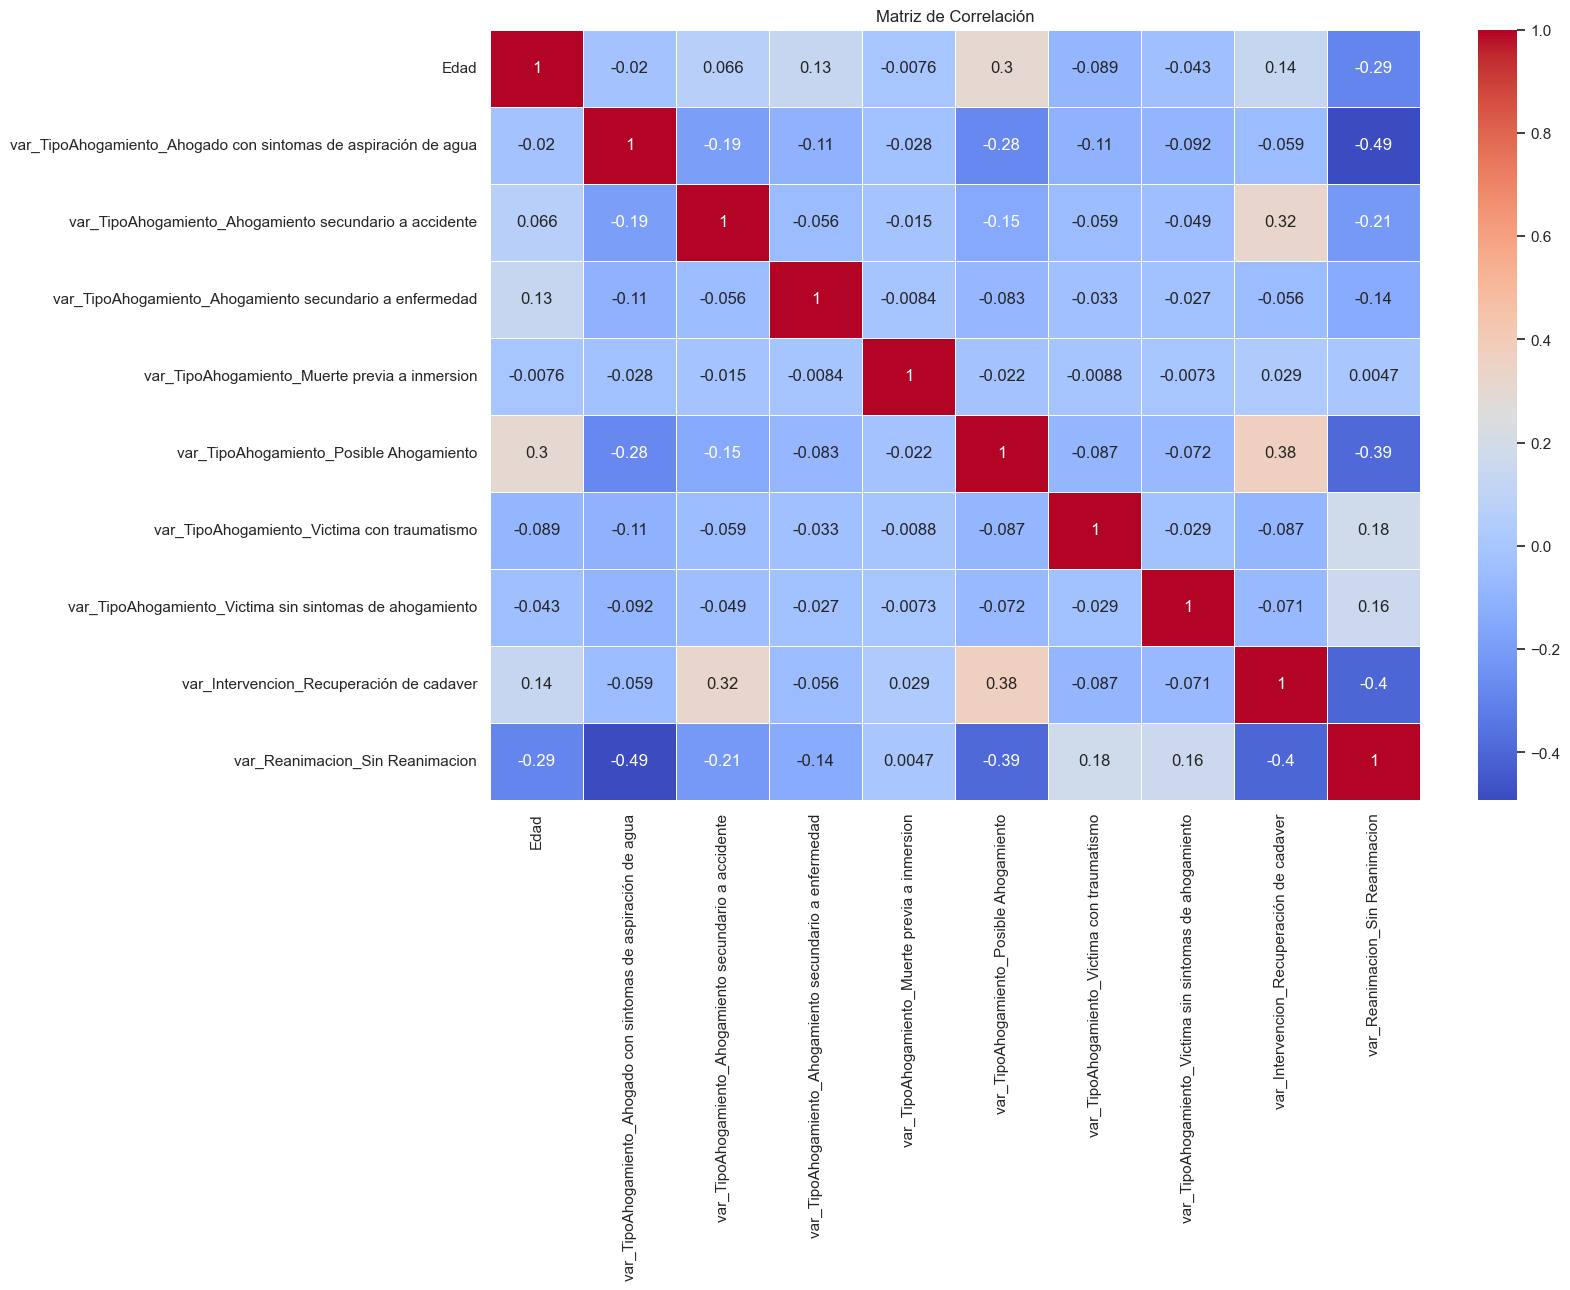

In [279]:
# Calculo de la matriz de correlación
corr_matrix = X_selected.corr()

# Crea un mapa de calor de la matriz de correlación
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

## <span style=color:darkblue>Model Fitting</span>

In [280]:
# Aplicamos el modelo de Regresión Logística sobre los datos que son relevantes para explicar el ahogamiento mortal 
X_train, X_test, y_train, y_test = train_test_split(X_selected, np.ravel(y), test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [281]:
# Realizamos predicciones del modelo sobre los datos de test
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [287]:
# Creamos la matriz de confusión para analizar los aciertos y errores
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

<AxesSubplot: >

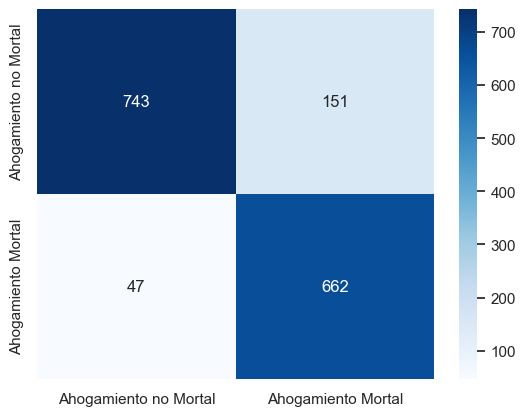

In [288]:
# Definimos las etiquetas de las clases
class_labels = ['Ahogamiento no Mortal', 'Ahogamiento Mortal']

# Plot de la matriz de confusión utilizando seaborn
sns.heatmap(confusion_matrix, annot=True, cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels, fmt='d', annot_kws={"fontsize": 12})

In [289]:
# Analizamos con más detalle las diferentes métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88       894
           1       0.81      0.93      0.87       709

    accuracy                           0.88      1603
   macro avg       0.88      0.88      0.88      1603
weighted avg       0.88      0.88      0.88      1603



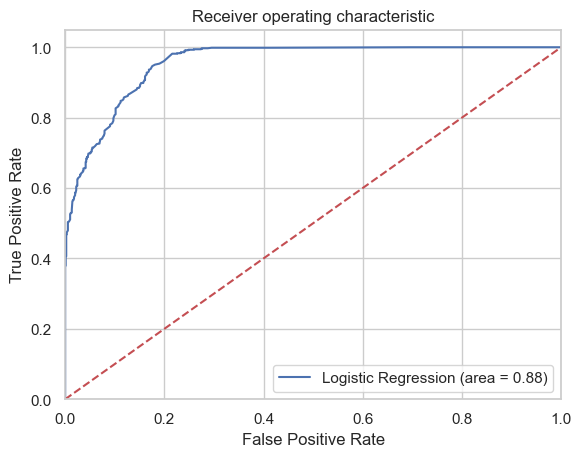

In [290]:
# Curva ROC
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

+ Con la imputación de missings sobre la variable edad obtenemos la misma precisión de modelo, lo único que varia son las categorias de las variables que intervienen para explicar si un ahogamiento es mortal de uno que no lo es. Las variables generales acaban siendo las mismas (Edad, Tipo de Ahogamiento Reanimación y Intervencion).

+ Para esta última aproximación obtenemos un 88% de precisión en el modelo, un 2% más que en el anterior modelo.